In [22]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure

In [23]:
sec = ADatabase("sec")
market = ADatabase("market")

In [24]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["assets","liabilities","adjclose"]


In [35]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["CIK"])
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = p.column_date_processing(sec.query("filings",{"cik":cik}))
        filings["year"] = [x.year if x.quarter < 4 else x.year + 1 for x in filings["date"]]
        filings["quarter"] = [x.quarter + 1 if x.quarter < 4 else 1 for x in filings["date"]]
        price = price.drop(["date","ticker"],axis=1).merge(filings.drop(["date","cik"],axis=1),on=["year","quarter"],how="left").groupby(["year","quarter"]).mean().reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-1)
        factors_df.append(price[["year","quarter","ticker","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

26it [00:01, 20.77it/s]

AMTM 'date'


63it [00:03, 19.52it/s]

BRK.B 'date'


67it [00:03, 17.90it/s]

BLK 'date'


78it [00:04, 17.48it/s]

BF.B 'date'


502it [00:29, 17.01it/s]

ZTS 'date'


In [36]:
model = XGBRegressor()
training_data = factors_df[(factors_df["year"]>=2013) & (factors_df["year"]<2020)]
sim = factors_df[(factors_df["year"]>=2019)]
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

C:\Users\eric\AppData\Local\Temp\ipykernel_12808\3065270520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim["prediction"] = model.predict(sim[factors])


In [37]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 13%|███████████████████▏                                                                                                                                     | 63/502 [00:03<00:21, 20.41it/s]

'date'


 16%|████████████████████████                                                                                                                                 | 79/502 [00:04<00:22, 18.96it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:28<00:00, 17.92it/s]

'date'


In [38]:
simulation = pd.concat(prices).dropna()

In [39]:
simulation["factor"] = simulation["prediction"]/simulation["adjclose"] - 1

In [40]:
simulation["rank"] = simulation.groupby(["date"])["factor"].rank(method="dense",ascending=False).astype(int)

In [41]:
simulation["exposure"] = [1 if x < simulation["rank"].max() * 0.20 else -1 if x > simulation["rank"].max() * 0.80 else 0.5 for x in simulation["rank"]]

In [60]:
simulation["sell_price"] = simulation["adjclose"]
simulation.sort_values("date",inplace=True)
trades = simulation[simulation["year"]>=2020][["year","quarter","ticker","exposure","adjclose","sell_price"]].groupby(["year","quarter","ticker"]).agg({"exposure":"first","adjclose":"first","sell_price":"last"}).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"]
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()

In [65]:
trades.sort_values("return",ascending=False).head(40)

,year,quarter,ticker,exposure,adjclose,sell_price,return
8255,2024,1,SMCI,1.0,28.545000,101.003000,2.538378
920,2020,2,TRGP,1.0,5.347719,18.362795,2.433762
605,2020,2,CZR,1.0,11.690000,40.060000,2.426861
522,2020,2,APA,1.0,3.677635,12.386293,2.368005
1828,2020,4,PLTR,1.0,9.460000,23.550000,1.489429
925,2020,2,TSLA,1.0,32.104000,71.987333,1.242317
6774,2023,2,SMCI,1.0,11.272000,24.925000,1.211231
9707,2024,4,PLTR,1.0,36.460000,80.550000,1.209270
798,2020,2,MRNA,1.0,29.670000,64.210000,1.164139
2385,2021,1,TPL,1.0,238.723286,502.674591,1.105679


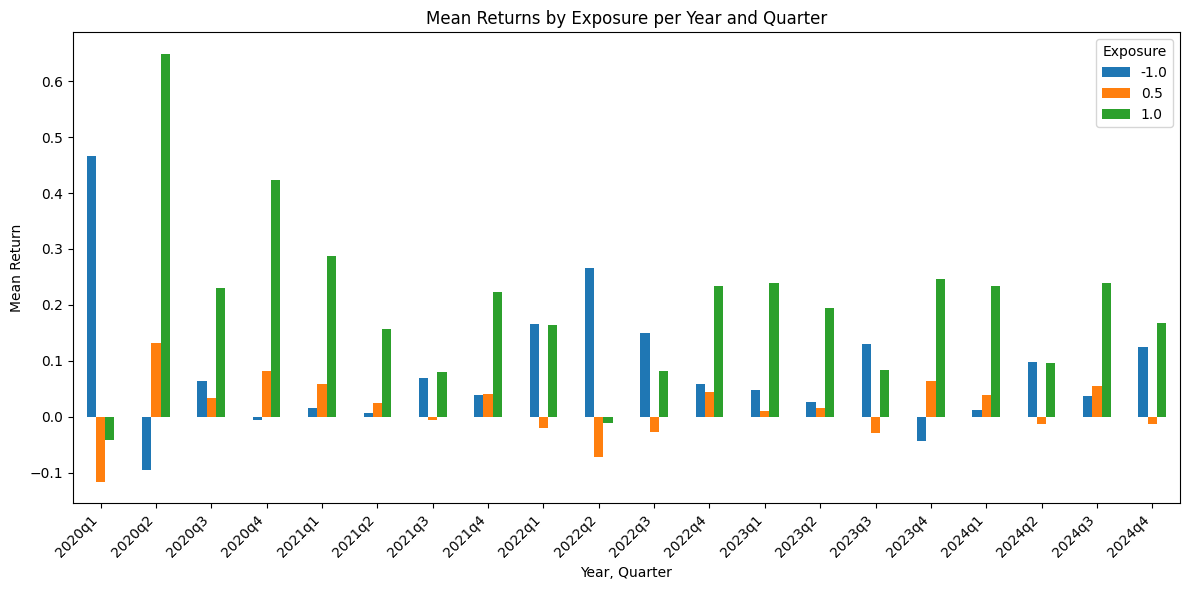

In [62]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()
